# 0. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertModel, BertTokenizer
import gc
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime
import random
import shap
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pickle
import scipy as sp

# 1. Load the dataset, set up the GPU, install the transformer

In [ ]:
path='/content/drive/MyDrive/fake-news-adversarial-benchmark/'



# Define paths liar

dataset='LIAR'
model_path = path+'Model/liar_model2'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/liar/'


path_csv= path_data_created+'liar_1000.csv'

shap_path=path_data_created+'shapvalues_1000_liar.sav'
path_labels=path_data_created+'labels_liar.npy'
outputs_path=path_data_created+'original_probs_liar_1000.pt'
"""
# Define paths Fake News

dataset='Fake News'
model_path = path+'Model/fn_model'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/fake_news/'

path_csv= path_data_created+'fake_news_1000.csv'
path_labels=path_data_created+'labels_fake_news.npy'
shap_path=path_data_created+'shapvalues_1000_fake_news.sav'
outputs_path=path_data_created+'original_outputs_fake_news_1000.pt'

# Define paths imdb

dataset='IMDB'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'

path_csv= path_data_created+'imdb_1000.csv'
path_labels=path_data_created+'labels_imdb.npy'

shap_path=path_data_created+'shapvalues_1000_imdb.sav'
outputs_path=path_data_created+'original_probs_imdb_1000.pt'

"""



"\n# Define paths Fake News\n\ndataset='Fake News'\nmodel_path = path+'Model/fn_model'\npath_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/fake_news/'\n\npath_csv= path_data_created+'fake_news_1000.csv'\npath_labels=path_data_created+'labels_fake_news.npy'\nshap_path=path_data_created+'shapvalues_1000_fake_news.sav' \noutputs_path=path_data_created+'original_outputs_fake_news_1000.pt'\n\n# Define paths imdb\n\ndataset='IMDB'\npath_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'\n\npath_csv= path_data_created+'imdb_1000.csv'\npath_labels=path_data_created+'labels_imdb.npy'\n\nshap_path=path_data_created+'shapvalues_1000_imdb.sav' \noutputs_path=path_data_created+'original_probs_imdb_1000.pt'\n\n"

In [ ]:
# Load the tokenizer
if dataset == 'IMDB':
  print('Using IMDB trained tokenizer')
  !pip install textattack
  from transformers import AutoModelForSequenceClassification, AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
else:
  print('Using bert-base-uncased tokenizer')
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#



Using bert-base-uncased tokenizer


In [ ]:
path_final=path+'final_files/'+dataset+'/'
path_random=path_data_created+'random/'
df = pd.read_csv(path_csv)

In [ ]:
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda:
    torch.cuda.manual_seed(0)

print("Using GPU: {}".format(use_cuda))

Using GPU: True


# Use BERT Architecture with random weights

In [ ]:
#https://github.com/huggingface/transformers/issues/2649
#model without pretrained weights
config = BertConfig()
model_without_Pretrained = BertForSequenceClassification(config)
model_without_Pretrained.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#Compute SHAP values

In [ ]:
# define a prediction function https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#nlp_model
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=512, truncation=True) for v in x]).cuda()
    outputs = model_without_Pretrained(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val


In [ ]:
 explainer = shap.Explainer(f, tokenizer)

In [ ]:
shap_values_rand = explainer(df['statement'], batch_size=20)

Partition explainer: 1001it [57:23,  3.45s/it]


In [ ]:
pickle.dump(shap_values_rand, open((path_random+"shap_values_rand.sav"), 'wb'))

# a few graphs to get an overview

In [ ]:
labels = np.load(path_labels)

shap_values = pickle.load(open(shap_path, 'rb'))
original_probs= torch.load(outputs_path, map_location=torch.device('cpu'))

labels=torch.LongTensor(labels)

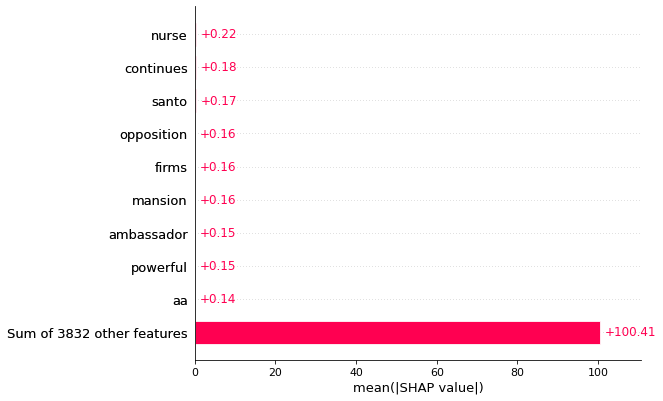

In [ ]:
shap.plots.bar(shap_values_rand)

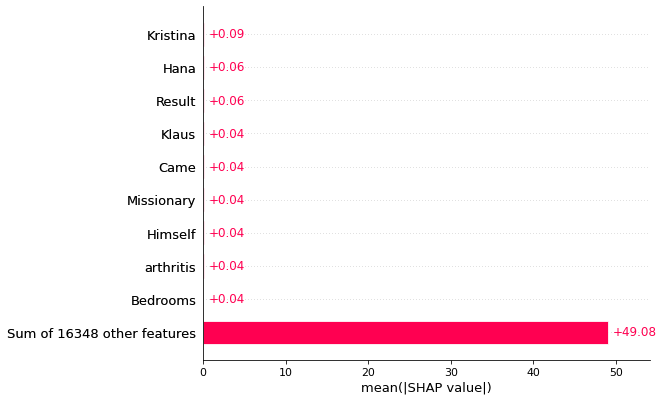

In [ ]:
shap.plots.bar(shap_values_rand)

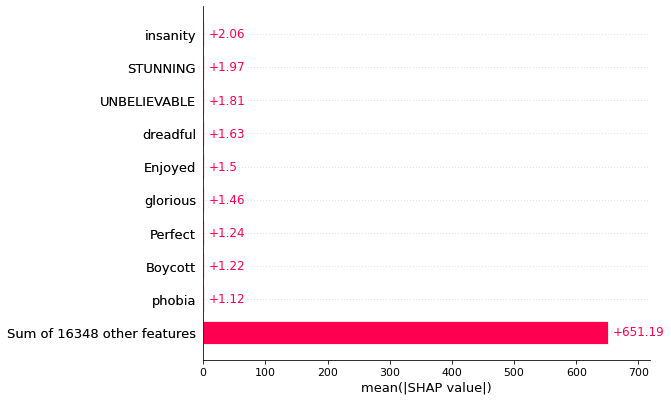

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.text(shap_values[1])

In [ ]:
shap.plots.text(shap_values_rand[1])

# get the spearman correlation

In [ ]:
#https://github.com/langlrsw/MEED/blob/master/imdb/eval_methods.py

#alternative https://huggingface.co/spaces/evaluate-metric/spearmanr
def eval_correlation(selection_1, selection_2, flag_abs=False):
    # Spearman Correlation Coefficient
    selection_1, selection_2 = np.reshape(selection_1, -1), np.reshape(selection_2, -1)
    if flag_abs:
        selection_1, selection_2 = np.abs(selection_1), np.abs(selection_2)

    temp_1, temp_2 = selection_1.argsort(), selection_2.argsort()
    ranks_1, ranks_2 = np.empty_like(temp_1), np.empty_like(temp_2)
    ranks_1[temp_1], ranks_2[temp_2] = np.arange(len(selection_1)), np.arange(len(selection_2))

    return np.corrcoef(selection_1, selection_2)[0][1]

In [ ]:
#get global correlation
def flatten(l):
    return [item for sublist in l for item in sublist]
shap_values_flat=flatten(shap_values.values)
shap_values_rand_flat=flatten(shap_values_rand.values)
print(eval_correlation(shap_values_flat, shap_values_rand_flat, flag_abs=True))
eval_correlation(shap_values_flat, shap_values_rand_flat)

ValueError: ignored

In [ ]:
#getting the mean
#https://stats.stackexchange.com/questions/8019/averaging-correlation-values

mean_correlation = np.mean([eval_correlation(shap_values.values[i], shap_values_rand.values[i]) for i in range(len(shap_values))])
mean_correlation


In [ ]:
print(torch.cuda.get_device_name(device))

NVIDIA A100-SXM4-40GB


# Use BERT base (without finetuning)

In [ ]:
'''

#https://discuss.huggingface.co/t/tips-for-pretraining-bert-from-scratch/1175
# load pre-trained config
config = BertConfig.from_pretrained("bert-base-uncased",
                                    num_labels = 2,
                                    output_attentions = False,
                                    output_hidden_states = False,)

# pass the config to model constructor instead of from_pretrained
# this creates the model as per the params in config
# but with weights randomly initialized
model_rand = BertForSequenceClassification(config)
model_rand.to(device)
'''

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)